In [21]:
from datetime import datetime, date, time, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from utils import *
from median_optimization import optimal_median

In [22]:
TRAIN_START = "2023-10-02 00:00"
TRAIN_END = "2023-12-10 23:59"


TEST_START = "2023-10-28 00:00"
TEST_END = "2023-10-31 23:59"
test_rain_dates = []

PUBLIC_START = "2023-10-21 00:00"
PUBLIC_END = "2023-10-24 23:59"
public_rain_dates = []

PRIVATE_START = "2023-12-18 00:00"
PRIVARE_END = "2023-12-24 23:59"
private_rain_dates = [date(2023, 12, 19), date(2023,12,20)]


In [23]:
with open("./cache/small_data_cache.pkl", "rb") as f:
    df = pd.read_pickle(f)
with open("../html.2023.final.data/sno_test_set.txt") as f:
    ntu_snos = [l.strip() for l in f.read().splitlines()]
with open("./cache/10-03_12_09_rain.pkl","rb") as f:
    rain_df = pd.read_pickle(f)

In [24]:
print(rain_df)
print(df)

                datetime  rain
0    2023-10-03 01:00:00   0.0
1    2023-10-03 02:00:00   0.0
2    2023-10-03 03:00:00   0.0
3    2023-10-03 04:00:00   0.0
4    2023-10-03 05:00:00   0.0
...                  ...   ...
2227 2023-12-09 20:00:00   0.0
2228 2023-12-09 21:00:00   0.0
2229 2023-12-09 22:00:00   0.0
2230 2023-12-09 23:00:00   0.0
2231 2023-12-10 00:00:00   0.0

[1632 rows x 2 columns]
                    time        sno  tot  sbi act
0    2023-10-02 00:00:00  500101001   28   12   1
1    2023-10-02 00:01:00  500101001   28   12   1
2    2023-10-02 00:02:00  500101001   28   13   1
3    2023-10-02 00:03:00  500101001   28   13   1
4    2023-10-02 00:04:00  500101001   28   13   1
...                  ...        ...  ...  ...  ..
1395 2023-12-10 23:15:00  500119091   18    0   1
1396 2023-12-10 23:16:00  500119091   18    0   1
1397 2023-12-10 23:17:00  500119091   18    0   1
1398 2023-12-10 23:18:00  500119091   18    0   1
1399 2023-12-10 23:19:00  500119091   18    0   1

[9

In [25]:
ntu_tots = get_tot(df, ntu_snos)
# the data looks like this:
"""
     datetime               sno      tot   sbi   bemp  act
0    2023-10-02 00:00:00  500101001  28.0  12.0  16.0   1
1    2023-10-02 00:01:00  500101001  28.0  12.0  16.0   1
2    2023-10-02 00:02:00  500101001  28.0  13.0  15.0   1
...
"""
holidays = [d for d in date_range(start=TRAIN_START, end=PRIVARE_END) if is_holiday(d)]

In [26]:
df['datehour'] = df['time'].dt.floor("H")


In [27]:
rain_df.rename(columns={'datetime':'datehour'},inplace=True)


argument rain to df

In [28]:
df = df.merge(rain_df,on='datehour',how='left')
df['rain'].fillna(0,inplace=True)
print(df)
df.describe()

                       time        sno  tot  sbi act            datehour  rain
0       2023-10-02 00:00:00  500101001   28   12   1 2023-10-02 00:00:00   0.0
1       2023-10-02 00:01:00  500101001   28   12   1 2023-10-02 00:00:00   0.0
2       2023-10-02 00:02:00  500101001   28   13   1 2023-10-02 00:00:00   0.0
3       2023-10-02 00:03:00  500101001   28   13   1 2023-10-02 00:00:00   0.0
4       2023-10-02 00:04:00  500101001   28   13   1 2023-10-02 00:00:00   0.0
...                     ...        ...  ...  ...  ..                 ...   ...
9710084 2023-12-10 23:15:00  500119091   18    0   1 2023-12-10 23:00:00   0.0
9710085 2023-12-10 23:16:00  500119091   18    0   1 2023-12-10 23:00:00   0.0
9710086 2023-12-10 23:17:00  500119091   18    0   1 2023-12-10 23:00:00   0.0
9710087 2023-12-10 23:18:00  500119091   18    0   1 2023-12-10 23:00:00   0.0
9710088 2023-12-10 23:19:00  500119091   18    0   1 2023-12-10 23:00:00   0.0

[9710089 rows x 7 columns]


,time,tot,sbi,datehour,rain
count,9710089,9.710089e+06,9.710089e+06,9710089,9.710089e+06
mean,2023-11-07 15:09:54.800780800,2.579011e+01,7.598337e+00,2023-11-07 14:40:26.217227264,1.582507e-01
min,2023-10-02 00:00:00,5.000000e+00,0.000000e+00,2023-10-02 00:00:00,0.000000e+00
25%,2023-10-25 03:51:00,1.500000e+01,1.000000e+00,2023-10-25 03:00:00,0.000000e+00
50%,2023-11-09 05:11:00,2.000000e+01,4.000000e+00,2023-11-09 05:00:00,0.000000e+00
75%,2023-11-24 07:24:00,3.000000e+01,1.100000e+01,2023-11-24 07:00:00,0.000000e+00
max,2023-12-10 23:19:00,9.900000e+01,9.900000e+01,2023-12-10 23:00:00,9.000000e+00
std,NaN,1.701816e+01,1.035669e+01,NaN,6.654206e-01


In [29]:
morning_filter = (df["datehour"].dt.hour >= 7) & (df['datehour'].dt.hour <= 21)
rain_hours = df['datehour'][ (df["sno"] == "500101001") & morning_filter &(df['rain'] >= 0.3) ].drop_duplicates() # 0.3 for dribble , 0.5 for small rain
rain_dates = rain_hours.dt.date.drop_duplicates()

print(rain_dates.describe()) # 0.3: 28, 0.5: 15 total:63-62 days

date_rain_hour_cnt = rain_hours.dt.date.value_counts()
print(date_rain_hour_cnt)

count             28
unique            28
top       2023-10-03
freq               1
Name: datehour, dtype: object
datehour
2023-10-04    15
2023-12-04    15
2023-11-30    14
2023-12-06    12
2023-12-01    11
2023-10-03    11
2023-10-05    10
2023-11-16    10
2023-11-14     9
2023-11-29     8
2023-10-20     8
2023-11-12     7
2023-11-10     7
2023-11-26     7
2023-11-24     7
2023-11-25     7
2023-12-05     7
2023-12-03     6
2023-10-28     6
2023-10-27     5
2023-10-08     4
2023-10-29     4
2023-10-06     3
2023-10-07     2
2023-11-11     2
2023-10-09     2
2023-12-02     2
2023-10-31     1
Name: count, dtype: int64


In [30]:
long_rain_dates = rain_dates[rain_dates.isin(date_rain_hour_cnt.index[date_rain_hour_cnt >= 7])]
print(long_rain_dates) # 12
print(long_rain_dates.describe())
rainy_dates = long_rain_dates.array # 12
#print(rainy_dates)

161880     2023-10-03
322980     2023-10-04
484260     2023-10-05
2241116    2023-10-20
4982204    2023-11-10
5304404    2023-11-12
5627264    2023-11-14
5949764    2023-11-16
7233156    2023-11-24
7394496    2023-11-25
7555716    2023-11-26
8025556    2023-11-29
8186836    2023-11-30
8330453    2023-12-01
8804292    2023-12-04
8964452    2023-12-05
9123268    2023-12-06
Name: datehour, dtype: object
count             17
unique            17
top       2023-10-03
freq               1
Name: datehour, dtype: object


[ datetime.date(2023, 10, 3),  datetime.date(2023, 10, 4),
  datetime.date(2023, 10, 5),  datetime.date(2023, 10, 6),
  datetime.date(2023, 10, 8), datetime.date(2023, 10, 20),
 datetime.date(2023, 10, 28), datetime.date(2023, 11, 16),
 datetime.date(2023, 11, 26), datetime.date(2023, 11, 30),
  datetime.date(2023, 12, 4),  datetime.date(2023, 12, 6)]

delete rain processing variables

In [31]:
del rain_df
del morning_filter
del rain_hours, rain_dates
del date_rain_hour_cnt
del long_rain_dates

Only one main table. Then always slice from it

In [32]:
#old_tb = pd.pivot_table(df, index="time", columns="sno", values="sbi") # for patching
tb = (
    pd.pivot_table(df, index="time", columns="sno", values="sbi")
    .resample("20min")
    .agg("first")
)
# exclude long holidays
#tb_rainy = tb[~tb.index.to_series().dt.date.isin(long_holiday)]
#tb_sunny = tb_rainy[~tb_rainy.index.to_series().dt.date.isin(rainy_dates)]
# [] only provides view,so assigning to it cause warning


Training

In [33]:
def prep_train_data(tb)->pd.DataFrame:
    train = tb[tb.index.to_series().dt.date.isin(date_range(TRAIN_START, TRAIN_END))].copy()
    train.reset_index(names="time", inplace=True)
    train["weekday"] = train["time"].dt.weekday
    train.set_index(["time", "weekday"], inplace=True)
    return train

def prep_sd_data(train,sno)->pd.DataFrame:
    sd = train[sno].to_frame()
    sd.rename(columns={sno: "sbi"}, inplace=True)
    sd.reset_index(["time", "weekday"], inplace=True)
    sd["date"] = sd["time"].dt.date
    sd["time"] = sd["time"].dt.time
    sd = pd.pivot_table(sd, index=["date", "weekday"], columns="time", values="sbi")
    return sd

#def trans(s):
#    if s in range(5):
#        return 0
#    return s

sd:
```
time                	00:00:00  00:20:00  00:40:00  01:00:00  01:20:00  ...
date       weekday 		sbi
```

Training data

In [34]:
train = prep_train_data(tb)

result_df = pd.DataFrame(
            columns=ntu_snos,
            index=pd.MultiIndex.from_product(
                [[True,False],pd.date_range("00:00", "23:59", freq="20min").time, [d for d in range(7)]],
                names=("rain","time", "weekday"),
            ),
            dtype=np.float64,
        )
        
Ein={True:0.0,False:0.0} # rain

In [35]:
def plot(sd,sno):
    dsd = sd.droplevel('weekday')
    tsd = dsd.T
    rain_filter = dsd.index.to_series().isin(rainy_dates)
    trdsd = dsd[rain_filter].T
    tsdsd = dsd[~rain_filter].T

    ax = trdsd.plot(figsize=(20, 6), color="blue", lw=0.8,  legend=False)
    ax = tsdsd.plot(ax=ax, color="green", lw=0.3, alpha=0.4,  legend=False)
    mean = tsd.mean(axis=1)
    ax = mean.plot(ax=ax, color="red", lw=2, legend=False)
    std = tsd.std(axis=1)
    ax = std.plot(ax=ax, color="orange", legend=False)
    
    # sunny weekday avg
    twsdsd = sd[(~rain_filter).values].droplevel('date').groupby(level=0).mean().T
    ax = twsdsd.plot(ax=ax, lw=2)

    plt.savefig(f"./week_rain_lines/{sno}.png")
    plt.close(ax.get_figure())

In [36]:
#for sno in ntu_snos:
#    plot(prep_sd_data(train,sno),sno)

In [37]:
for sno, tot in zip(ntu_snos, ntu_tots): # column as 0-th index
    #station data
    sd = prep_sd_data(train,sno)
    
    # TODO prepare drawing
    for rain in [True,False]:
        if not rain:
            sd = sd[~sd.index.get_level_values("date").isin(rainy_dates)]
        #for day in range(7):  # 0 to 6
        # classify dates
        grouped_stats = sd.droplevel('date').groupby(level=0).mean().drop([5, 6]).T
    
        print(sno)
        #print(grouped_stats)
        time_series_data = grouped_stats.iloc[:, :5].values.T
        print(time_series_data.shape)
        # Initialize an empty distance matrix
        distance_matrix = np.zeros((5, 5))

        # Calculate the distance between each pair of time series using DTW
        for i in range(5):
            for j in range(i):
                distance = euclidean(time_series_data[i], time_series_data[j])
                distance_matrix[i][j] = distance_matrix[j][i]= distance
                #print(f"{i} vs {j}")
                #print(distance)
                #print(path)
        print(distance_matrix)

        means = np.mean(distance_matrix, axis=1)
        std=  np.std(means)
        mean = np.mean(means)
        print("means:")
        print(means)
        print(f"mean: {mean}")
        print(f"std: {std}")
        print(f"cv: {std/mean}")
            for t in sd.columns:
                # print(t, sno)
                sbi, err = optimal_median(
                    y_true=sd.loc[
                        sd.index.get_level_values("weekday") == day, t
                    ].to_numpy(),
                    tot=tot,
                )
                Ein[rain] += err
                # print(f"{t} sbi:{sbi}   err: {err}")
                result_df.at[(rain, t, day), sno] = sbi
                # result_df.at[[t, isholiday], sno] = np.float64(sbi)
                # print(result_df.at[t, sno])

#assert not result_df.isnull().values.any()
#print(result_df.xs(True).size)
#print(result_df.xs(False).size)
for rain in [True, False]:
    Ein[rain] /= result_df.xs(rain).size
    print(("All" if rain else "Sunny")+ f" Ein = {Ein[rain]}")

All Ein = 0.25259035822679565
Sunny Ein = 0.23917791366846078


Self evaluation (Test)

In [38]:
test = tb[tb.index.to_series().dt.date.isin(date_range(TEST_START, TEST_END))]
y_test = test.values

print_time_ranges(TRAIN_START, TRAIN_END, TEST_START, TEST_END)


Train: 10/02 - 12/10
Test: 10/28 - 10/31


In [39]:
ftr = list(
    np.stack([[True]*72+[False]*(test.shape[0]-72),test.index.time, test.index.to_series().dt.weekday]).T
)
y_pred = result_df.loc[ftr].values
local_test_range = pd.date_range(TEST_START, TEST_END, freq="20min")
assert y_test.shape == y_pred.shape , "test pred shape not matched"
# print(y_test.shape) #
# print(y_pred.shape)

(288, 112) \
(288, 112)

MAE:  0.12018016471706486
Score:  0.21312100364151104


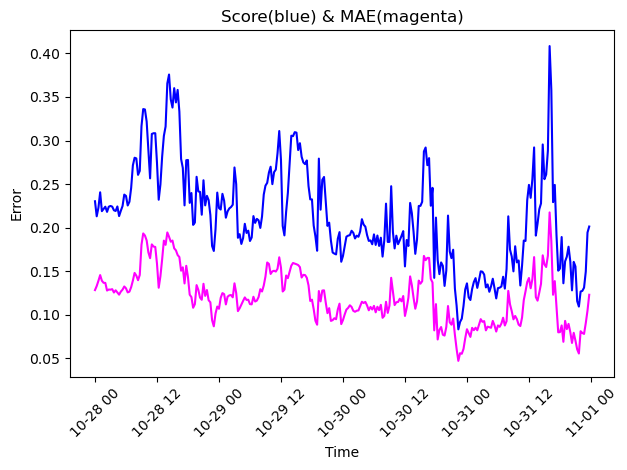

In [40]:
evaluation(y_test, y_pred, ntu_tots, local_test_range)


all sunny \
MAE:  0.13275823190272154 \
Score:  0.24003751756886713

all data \
MAE:  0.1229537906365303 \
Score:  0.21939612130515754

rain+sunny \
MAE:  0.12230290642321821 \
Score:  0.2167087889314868


does the same at public test set (2023/10/21 - 2023/10/24)

In [41]:
public_test_range = pd.date_range(PUBLIC_START, PUBLIC_END, freq="20min")
# list makes indexer 1D, or it is an 2D indexer
ftr = list(
    np.stack([[False]*(4*72),public_test_range.time, public_test_range.weekday]).T
)
y_public_df = result_df.loc[ftr]
print("y_public_df Before")
print(y_public_df)

y_public_df Before
                        500101001  500101002  500101003  500101004  500101005  \
rain  time     weekday                                                          
False 00:00:00 5              4.0        4.0       16.0       10.0        2.0   
      00:20:00 5              4.0        3.0       16.0       10.0        2.0   
      00:40:00 5              2.0        1.0       16.0        9.0        2.0   
      01:00:00 5              2.0        3.0       16.0       10.0        4.0   
      01:20:00 5              3.0        3.0       16.0       11.0        5.0   
...                           ...        ...        ...        ...        ...   
      22:20:00 1              2.0        1.0        2.0        0.0        1.0   
      22:40:00 1              5.0        1.0        2.0        0.0        1.0   
      23:00:00 1              2.0        1.0       15.0        2.0        1.0   
      23:20:00 1              3.0        0.0       15.0        2.0        1.0   
      23:

Check public

In [42]:
print("y_public_df After")
print(y_public_df)

y_public_df After
                        500101001  500101002  500101003  500101004  500101005  \
rain  time     weekday                                                          
False 00:00:00 5              4.0        4.0       16.0       10.0        2.0   
      00:20:00 5              4.0        3.0       16.0       10.0        2.0   
      00:40:00 5              2.0        1.0       16.0        9.0        2.0   
      01:00:00 5              2.0        3.0       16.0       10.0        4.0   
      01:20:00 5              3.0        3.0       16.0       11.0        5.0   
...                           ...        ...        ...        ...        ...   
      22:20:00 1              2.0        1.0        2.0        0.0        1.0   
      22:40:00 1              5.0        1.0        2.0        0.0        1.0   
      23:00:00 1              2.0        1.0       15.0        2.0        1.0   
      23:20:00 1              3.0        0.0       15.0        2.0        1.0   
      23:4

In [43]:
for col, tot in zip(y_public_df.columns, ntu_tots):
    y_public_df[col] = y_public_df[col].clip(lower=0, upper=tot)
y_public_test = y_public_df.values
public_test_df = pd.DataFrame(y_public_test, columns=ntu_snos, index=public_test_range)

In [44]:
private_test_range = pd.date_range(PRIVATE_START, PRIVARE_END, freq="20min")
ftr = list(
    np.stack(
        [[d in private_rain_dates for d in private_test_range.date],private_test_range.time, private_test_range.weekday]
    ).T
)
y_private_df = result_df.loc[ftr]

In [45]:
y_private_test = y_private_df.values
private_test_df = pd.DataFrame(
    y_private_test, columns=ntu_snos, index=private_test_range
)

In [46]:
tmp = pd.concat(
    [
        public_test_df,
        private_test_df,
    ]
)
# reset_index: old index => "time" column
# id_vars: fixed column like index
# var_name: columns.name to "sno" column
# value_name: value => "sbi" column
tmp = tmp.reset_index(names="time").melt(
    id_vars="time", var_name="sno", value_name="sbi"
)
out_df = pd.DataFrame(
    {
        "id": (
            tmp["time"].dt.strftime("%Y%m%d")
            + "_"
            + tmp["sno"]
            + "_"
            + tmp["time"].dt.strftime("%H:%M")
        ),
        "sbi": tmp["sbi"],
    }
)
out_df.to_csv(
    f"../submission/pub_pri_{datetime.now().strftime('%m-%d-%H-%M')}.csv", index=False
)
print("csv created")

csv created


TODO patch private<br>
Set the initial time


<br>
current_datetime = pd.to_datetime("2023-12-10 23:40")<br>
current_time = current_datetime.time()<br>
cur_data = old_tb[old_tb.index == current_datetime]<br>
print(cur_data)<br>
cur = old_tb[old_tb.index.to_series().dt.time == current_time]<br>
# Loop to fetch data for the next 20 minutes<br>
end_datetime = pd.to_datetime("2023-12-04 03:59")<br>
next_datetime = current_datetime<br>
td = timedelta(minutes=20)<br>
total_td = timedelta(minutes=0)<br>
while next_datetime <= end_datetime:<br>
    # Increment current_time by 20 minutes<br>
    next_datetime += td<br>
    next_time = next_datetime.time()<br>
    total_td += td<br>
    # Filter data from old_tb for the current time<br>
    nxt = old_tb[old_tb.index.to_series().dt.time == next_time]<br>
    diff = nxt - cur.shift(freq=total_td)<br>
    mean_diff = pd.pivot_table(diff.mean().reset_index(), columns="sno")<br>
    mean_diff.set_index(cur_data.index, inplace=True)<br>
    upd = cur_data + mean_diff<br>
    # print(upd)<br>
    patch_datetime = next_datetime + timedelta(minutes=1)<br>
    patch_time = patch_datetime.time()<br>
    upd.set_index([[patch_time], [0]], inplace=True)<br>
    y_private_df.loc[(patch_time, 0)] = upd<br>
print(y_private_df)<br>


convert the prediction to the required format